In [1]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [4]:
len(df.columns)

19

## Computing duration

In [5]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime

In [6]:
df['duration'] = df.duration.dt.total_seconds() / 60

In [7]:
df.duration.mean()

15.668995167332046

In [8]:
df.duration.std()

42.594351241920904

## Dropping outliers

In [9]:
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100

98.1220282212598

In [10]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

## One-hot encoding

In [11]:
categorical = ['PULocationID', 'DOLocationID']

In [12]:
df[categorical] = df[categorical].astype(str)

In [13]:
# Convert the selected categorical columns into a list of dictionaries
# Each dictionary represents one row of the dataframe
train_dicts = df[categorical].to_dict(orient='records')

In [14]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [15]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (3009173, 515)


## Train the model

In [16]:
target = 'duration'
y_train = df[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

In [18]:
print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE: 7.649261027826866


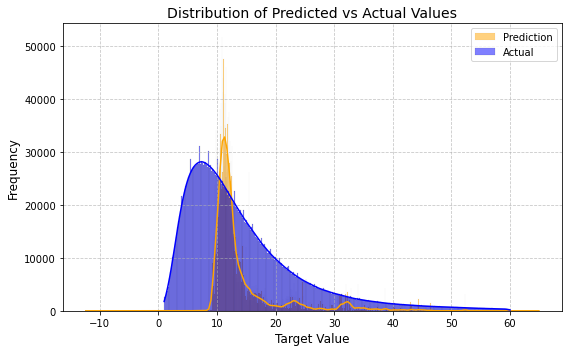

In [19]:
# Plot histograms to compare the distribution of predicted vs. actual values
# sns = seaborn; plt = matplotlib.pyplot

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility

# Plot prediction distribution
sns.histplot(y_pred, label='Prediction', color='orange', kde=True, alpha=0.5)

# Plot actual (true) distribution
sns.histplot(y_train, label='Actual', color='blue', kde=True, alpha=0.5)

# Add title, labels, and legend
plt.title('Distribution of Predicted vs Actual Values', fontsize=14)
plt.xlabel('Target Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()  # Show the legend to differentiate the two distributions
plt.grid(True, linestyle='--', alpha=0.7)  # Add light gridlines for clarity
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()


## Evaluating the model

In [20]:
import pandas as pd

CATEGORICAL = ['PULocationID', 'DOLocationID']
NEEDED_COLS = CATEGORICAL + ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

def read_data(filename):
    df = pd.read_parquet(filename, columns=NEEDED_COLS)

    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[CATEGORICAL] = df[CATEGORICAL].astype(str)
    return df


In [21]:
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [ ]:
val_dicts = df_val[CATEGORICAL].to_dict(orient='records')

: 

In [ ]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [ ]:
y_pred = lr.predict(X_val)

In [ ]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred)}')

Val RMSE: 61.02451207733901
